# 1. Introduction

Nitrogen is the main ingredient of fertilizer and is often applied in large quantities across the United States. However, nitrogen, in particular nitrate, leaching into streams is not only problematic because it is lost from the soils it was supposed to supplement, but it is also known to lead to environmental problems like eutrophication and the creation of dead zones further downstream as well as human health issues (Donner et al 2004; He & Lu 2016). Storm events increase NO3 export from streams because the increased volume of water means that there is a higher mass of exported solutes and because they can lead to increased NO3 leaching from soils as it is dissolved in the storm water (Duncan et al 2017; Jones et al 2017; Zimmer et al 2019). However, different land uses and environmental variables like geology and temperature can affect the effect of storms on discharge as well as nitrate cycling (Zhi & Li 2020). The goal of this project is to compare the Nitrate c-Q curves of five sites from across the United States to see how they compare to each other. This will allow us to get a rough idea of how different environmental variables may be affecting NO3 export during storm events and, more globally, how these sites respond to these events. 

Research question:
How does the NO3-discharge relationship vary across the United States during storm events?

# 2. Methods

## 2.1 Site description

Five NEON sites representing a range of climate conditions and watershed sizes were selected for this analysis and are presented in table 1. These sites are representative of a wider ecoclimatic domain, defined by NEON (figure 1). These sites are classified as wadable streams and sensors are located within a 1 km portion of the reach that is free of obstruction or major tributaries (NEON 2021). Watershed maps, along with study site locations are presented in figure 2. Each stream has two sensor stations where continuous physical and chemical data are collected. Supplementary chemistry samples are collected every two-weeks in the downstream portion of the reach. Data from the continuous sensors are the focus of these analyses, however the bi-weekly samples will be used to check for sensor accuracy and potential drift.


Table 1: Site name and environmental characteristics (Source: NEON Science 2021)

|Site Name|State|ID|Mean annual temperature (C)|Mean annual precipitation (mm)|Area (km2)|NLCD Vegetation class|
|---|---|---|---|---|---|---|
|Caribou Creek|AK|CARI|-3|262|31|Woody wetland|
|Hop Brook|MA|HOPB|7.9|1368|11.9|Evergreen forest, mixed forest|
|Walker Branch|TN|WALK|14.4|1340|1.1|Deciduous forest|
|Martha Creek|WA|MART|9.6|2329|6.3|Evergreen forest|
|Blacktail Deer Creek|WY|BLDE|3.6|481|37.8|Emergent herbaceous wetlands, shrub/scrub|



Figure 1: NEON ecoclimatic domains and site location

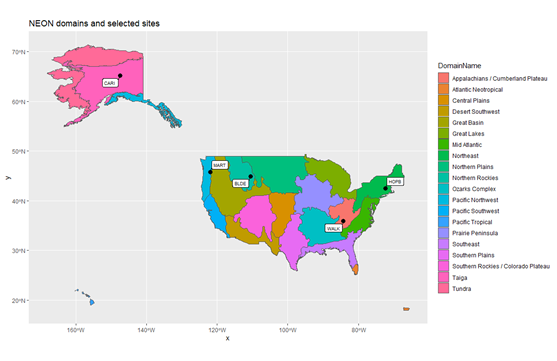

Figure 2: Watershed maps for the study sites. NEON site locations are identified in red.

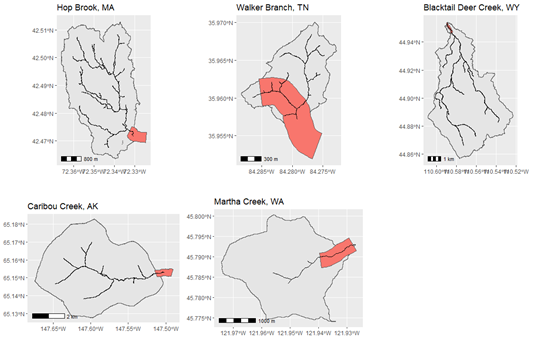


Data from 2019- 2021 are available for the selected sites and will be used for these analyses. The data products that will be used are: continuous discharge (DP4.00130.001 – 1 minute frequency), nitrate in surface water (DP1.20033.001– 15 minute frequency), and chemical properties of surface water (DP1.20093.001 – 2 week frequency). These data were downloaded in R using the NeonUtilities package, which converts and stacks the data into CSV files, along with metadata files.

## 2.2 Methods


In [3]:
# Import libraries for analysis
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as datetime
from scipy import stats

# Create a list of filenames
filenames = ['BLDE.csv', 'CARI.csv', 'HOPB.csv', 'MART.csv', 'WALK.csv']
# Create a list of site names
sites = ['BLDE', 'CARI', 'HOPB', 'MART', 'WALK']
# Create a liste of potential NA values
potentialNA = [9999, -9999, -8888, 'T', '<0.01', 'NA', 'NaN', 'nan', 'na', ' NA']
# Set a start date and an end date for analysis for all sites
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2021, 10, 31)

In [4]:
'''
Define functions to:
- Read the different data and remove flagged values
- Create timeseries plots of NO3 and discharge for each site
- 
'''

# Define functions to read the different data and remove flagged values
def readdisfunc(x):
    '''Read NEON continuous discharge data. Discharge units: l/s'''
    y = ('./Data/discharge/'+x)
    df = pd.read_csv(y, delimiter=',', header=0,
                     parse_dates=['endDate'], na_values=potentialNA)
    df = df.rename(columns={'endDate': "date",
                            "maxpostDischarge": "Q"
                            })
    df = df.set_index('date')
    df = df.tz_localize(None)
    df = df[start_date:end_date]
    df.loc[df['dischargeFinalQF'].eq(1), "Q"] = np.nan
    df = df[['Q']]
    return df

def readno3func(x):
    '''Read NEON sensor NO3 data. Units: no3mol = micromolar/l
    no3 = g/l'''
    y = ('./Data/sensorNO3/'+x)
    df = pd.read_csv(y, delimiter=',', header=0,
                     parse_dates=['endDateTime'], 
                     na_values=potentialNA, 
                     )
    df = df.rename(columns={'endDateTime': "date",
                            "surfWaterNitrateMean": "no3mol"
                            })
    df = df.set_index('date')
    df = df.tz_localize(None)
    df = df[~df.index.duplicated(keep='first')]
    df = df[start_date:end_date]
    df.loc[df['finalQF'].eq(1), "no3mol"] = np.nan
    df['no3'] = df['no3mol']*62.0049/1000000 
    df = df[['no3mol', 'no3']]
    return df


def readgrabfunc(x):
    '''Read NEON grab sample data. '''
    y = ('./Data/chemGrab/'+x)
    df = pd.read_csv(y, delimiter=',', header=0,
                     parse_dates=['collectDate'], na_values=potentialNA)
    df = df.rename(columns={'collectDate': "date",
                            ' NH4 - N': 'NH4-N', ' NO2 - N': 'NO2-N', 
                            ' NO3+NO2 - N':'NO3+NO2-N', ' TDN': 'TDN'
                            })
    df['date'] = df['date'].dt.round('15min') # Round time to the nearest 15 minute mark
    df = df.set_index('date')
    df = df[start_date:end_date]
    df = df[['NH4-N', 'NO2-N', 'NO3+NO2-N', 'TDN']]
    return df

def timeseriesplot(df): 
    fig, ax = plt.subplots()
    line1 = ax.plot(df['Q'], color = 'b', 
                     linestyle = '-', label = 'Discharge')    
    ax.set_ylabel('Discharge (l/s)', color = 'b')   
    ax.set_ylim(bottom = 0)
    fig.autofmt_xdate()                
    
    # Create second axis for discharge data on top of precipitation data
    ax2 = ax.twinx()
    line2 = ax2.plot(df['no3'], color = 'k', 
                     linestyle = '-', label = 'NO3')
    ax2.set_ylim(bottom = 0)
    ax2.set_ylabel('NO3 concentration (g/l)', color = 'k')  # create teal y-axis label
    ax.set_title(site)
    # Add a legend with data from both axes
    #ax2.invert_yaxis()
    lines = line1 + line2
    labs = [l.get_label() for l in lines]
    ax.legend(lines, labs, loc='upper left')
    return plt.show()


In [5]:
# Load data and merge dataframes

# Select a site
site = sites[0]
sitename = filenames[0]

# Load discharge data
disdat = readdisfunc(sitename)
# Load NO3 data
no3dat = readno3func(sitename)
# Load grab sample data
grabdat = readgrabfunc(sitename)

# Merge the grab sample and NO3 sensor dataframes
comp = pd.merge(no3dat, grabdat, how = 'right', left_index = True, 
                  right_index = True)
# Merge continuous discharge and sensor NO3 data based on their sampling time
dfdat = pd.merge(no3dat, disdat, how = 'left', left_index = True, 
                  right_index = True)
dfdat = dfdat.resample(rule = '15min').mean()


In [6]:
# Interpolate missing values (up to 1h) and count the number missing values
# Create a dataframe to add in changes in number of NAs
NAcount = pd.DataFrame(columns = ['site', 'Q', 'Qinterp', 'no3', 'no3interp'])
NAcount['site'] = sites
NAcount = NAcount.set_index('site')
NAcount.at[site,'Q'] = np.count_nonzero(~np.isnan(dfdat['Q']))
NAcount.at[site,'no3'] = np.count_nonzero(~np.isnan(dfdat['no3']))
# Interpolate values for gaps smaller than 1 hour
no3dat = no3dat.interpolate(method = 'linear', limit = 4)
NAcount.at[site,'no3interp'] = np.count_nonzero(~np.isnan(dfdat['no3']))
NAcount.at[site,'Qinterp'] = np.count_nonzero(~np.isnan(dfdat['Q']))


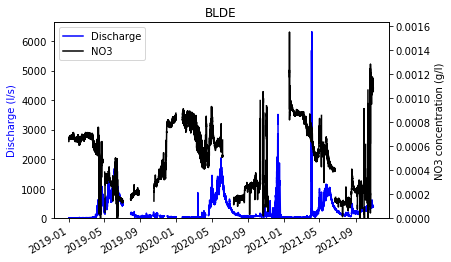

In [7]:
#%% Plot continuous discharge & NO3 vs time
timeseriesplot(dfdat)

### 2.2.1 Consistency of nitrate measurements

Nitrate concentrations are measured at two time frequencies: every 15 minutes using NO3 sensors and every two weeks from samples collected at two locations in each stream. To determine whether these measurements are consistent, a linear regression was calculated and assessed using a Pearson correlation coefficient for samples collected and recorded within a same 15 minute interval.  


The Pearson correlation coefficient between sensor and grab sample NO3 is 0.6555183673408391 p = 0.003143274171476582


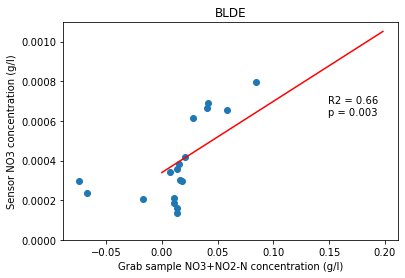

((0.6555183673408391, 0.003143274171476582), None)

In [8]:
# Compare grab sample NO3 values to sensor NO3 values

def compno3vals(df):

    compsub = df[['no3', 'TDN', 'NO3+NO2-N']]
    compsub = compsub[np.logical_not(np.isnan(compsub))]
    maxNO3 = max(compsub['NO3+NO2-N']) + 0.1
    idx = np.isfinite(compsub['no3']) & np.isfinite(compsub['NO3+NO2-N'])
    
    polyline = np.polyfit(compsub['NO3+NO2-N'][idx], compsub['no3'][idx], 1)
    linem = round(polyline[0], 2)
    lineb = round(polyline[1], 2)
    polyx = np.array([0, maxNO3])
    polyy = polyline[0]*polyx + polyline[1]
    
    # Calculate a Pearson correlation between the grab sample and sensor NO3
    coeff = stats.pearsonr(compsub['NO3+NO2-N'][idx], compsub['no3'][idx])
    coeffR2 = str(round(coeff[0], 2))
    coeffpval = str(round(coeff[1], 3))
    coeffitem = ('R2 = ' + coeffR2 + '\np = '+ coeffpval)
    print('The Pearson correlation coefficient between sensor and grab sample',
          'NO3 is', coeff[0], 'p =', coeff[1])
    # Plot sensor NO3 vs grab sample NO3+NO2-N
    fig, ax = plt.subplots()
    ax.scatter(x = df['NO3+NO2-N'], y = df['no3'])
    ax.plot(polyx, polyy, color = 'r')
    ax.set_xlabel('Grab sample NO3+NO2-N concentration (g/l)')
    ax.set_ylabel('Sensor NO3 concentration (g/l)')
    ax.set_ylim(bottom = 0)
    ax.annotate(coeffitem, xy = [(0.75*maxNO3), (0.6*polyy[1])])
    ax.set_title(site)

    return coeff, plt.show()

compno3vals(comp)

### 2.2.2 Discharge and nitrate relationship

A concentration-discharge relationship was estimated for each site using nitrate sensor data and continuous discharge measurements. A pearson correlation test was done to assess this relationship. 

In [9]:
# Compare discharge to NO3 measurements

# Calculate a Pearson correlation between discharge and sensor NO3 concentrations
idx = np.isfinite(dfdat['no3']) & np.isfinite(dfdat['Q'])
coeff = stats.pearsonr(dfdat['Q'][idx], dfdat['no3'][idx])
coeffR2 = str(round(coeff[0], 2))
coeffpval = str(round(coeff[1], 3))
coeffitem = ('R2 = ' + coeffR2 + '\np = '+ coeffpval)
print('The Pearson correlation coefficient between discharge and ',
      'NO3 concentration is', coeff[0], 'p =', coeff[1])

'''
# Calculate a linear regression between NO3 and discharge
## There is no real correlation for BLDE, check with other sites, but it
## doesn't seem worth it to do this
polyline = np.polyfit(dfBLDE['Q'][idx], dfBLDE['no3'][idx], 1)
linem = round(polyline[0], 2)
lineb = round(polyline[1], 2)
polyx = np.array([0, 6000])
polyy = polyline[0]*polyx + polyline[1]
'''


The Pearson correlation coefficient between discharge and  NO3 concentration is -0.06951139424570937 p = 5.396439875705918e-76


"\n# Calculate a linear regression between NO3 and discharge\n## There is no real correlation for BLDE, check with other sites, but it\n## doesn't seem worth it to do this\npolyline = np.polyfit(dfBLDE['Q'][idx], dfBLDE['no3'][idx], 1)\nlinem = round(polyline[0], 2)\nlineb = round(polyline[1], 2)\npolyx = np.array([0, 6000])\npolyy = polyline[0]*polyx + polyline[1]\n"

Text(0.5, 1.0, 'BLDE')

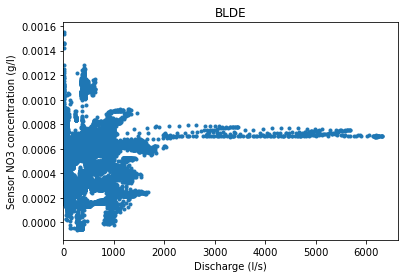

In [10]:
#%% Plot discharge vs sensor NO3 measurements

fig, ax = plt.subplots()
ax.scatter(x = dfdat['Q'], y = dfdat['no3'], marker = '.')
ax.set_xlabel('Discharge (l/s)')
ax.set_ylabel('Sensor NO3 concentration (g/l)')
ax.set_xlim(left = 0)
ax.set_title(site)


### 2.2.3 High discharge events and nitrate concentrations

At each site three high discharge events that had NO3 data were selected to assess the relationship between nitrate export and discharge. Figures were produced to represent hysteresis in NO3 export during a storm event (Duncan et al 2017). The range of NO3 concentration measurements for similar discharge values was calculated for each storm event. This value can then be used to help estimate the error on the gap-filled NO3 data during high flow events.  


In [11]:
# Pseudo-code for this analysis

'''
Select 3 storm events for each site (see lab 8-9 - create a dfstorm dataframe)

Plot discharge vs NO3 for the storm events and add labels with the datetimes or have 
the points link up to one another based on their datetimes (see Duncan et al 2017 - fig 4).

Calcuate difference between NO3 concentration for a given discharge value.
Compare hysteresis indices between each site/storm

'''

# This is about where I am at and still very much a work in progress

'\nSelect 3 storm events for each site (see lab 8-9 - create a dfstorm dataframe)\n\nPlot discharge vs NO3 for the storm events and add labels with the datetimes or have \nthe points link up to one another based on their datetimes (see Duncan et al 2017 - fig 4).\n\nCalcuate difference between NO3 concentration for a given discharge value.\nCompare hysteresis indices between each site/storm\n\n'

# 3. Results



## 3.1 Consistency of nitrate measurements

Out of five sites, grab samples and NO3 sensor measurements were correlated for only two sites: BLDE and CARI. Grab samples did not identify NO3 concentrations seperately and instead reported the N in NO2 and NO3 concentrations jointly. This difference could explain why the two values were poorly correlated for most sites: NO2 is a more dominant form of N at these sites than the others, which skews the grab sample values away from the sensor equivalent. These results could also indicate some form of sensor malfunction and the data was not flagged appropriately. 

Figure 3: Sensor measured NO3 concentration and grab sample NO2 + NO3-N concntrations. Pearson R2 values are given for each site.
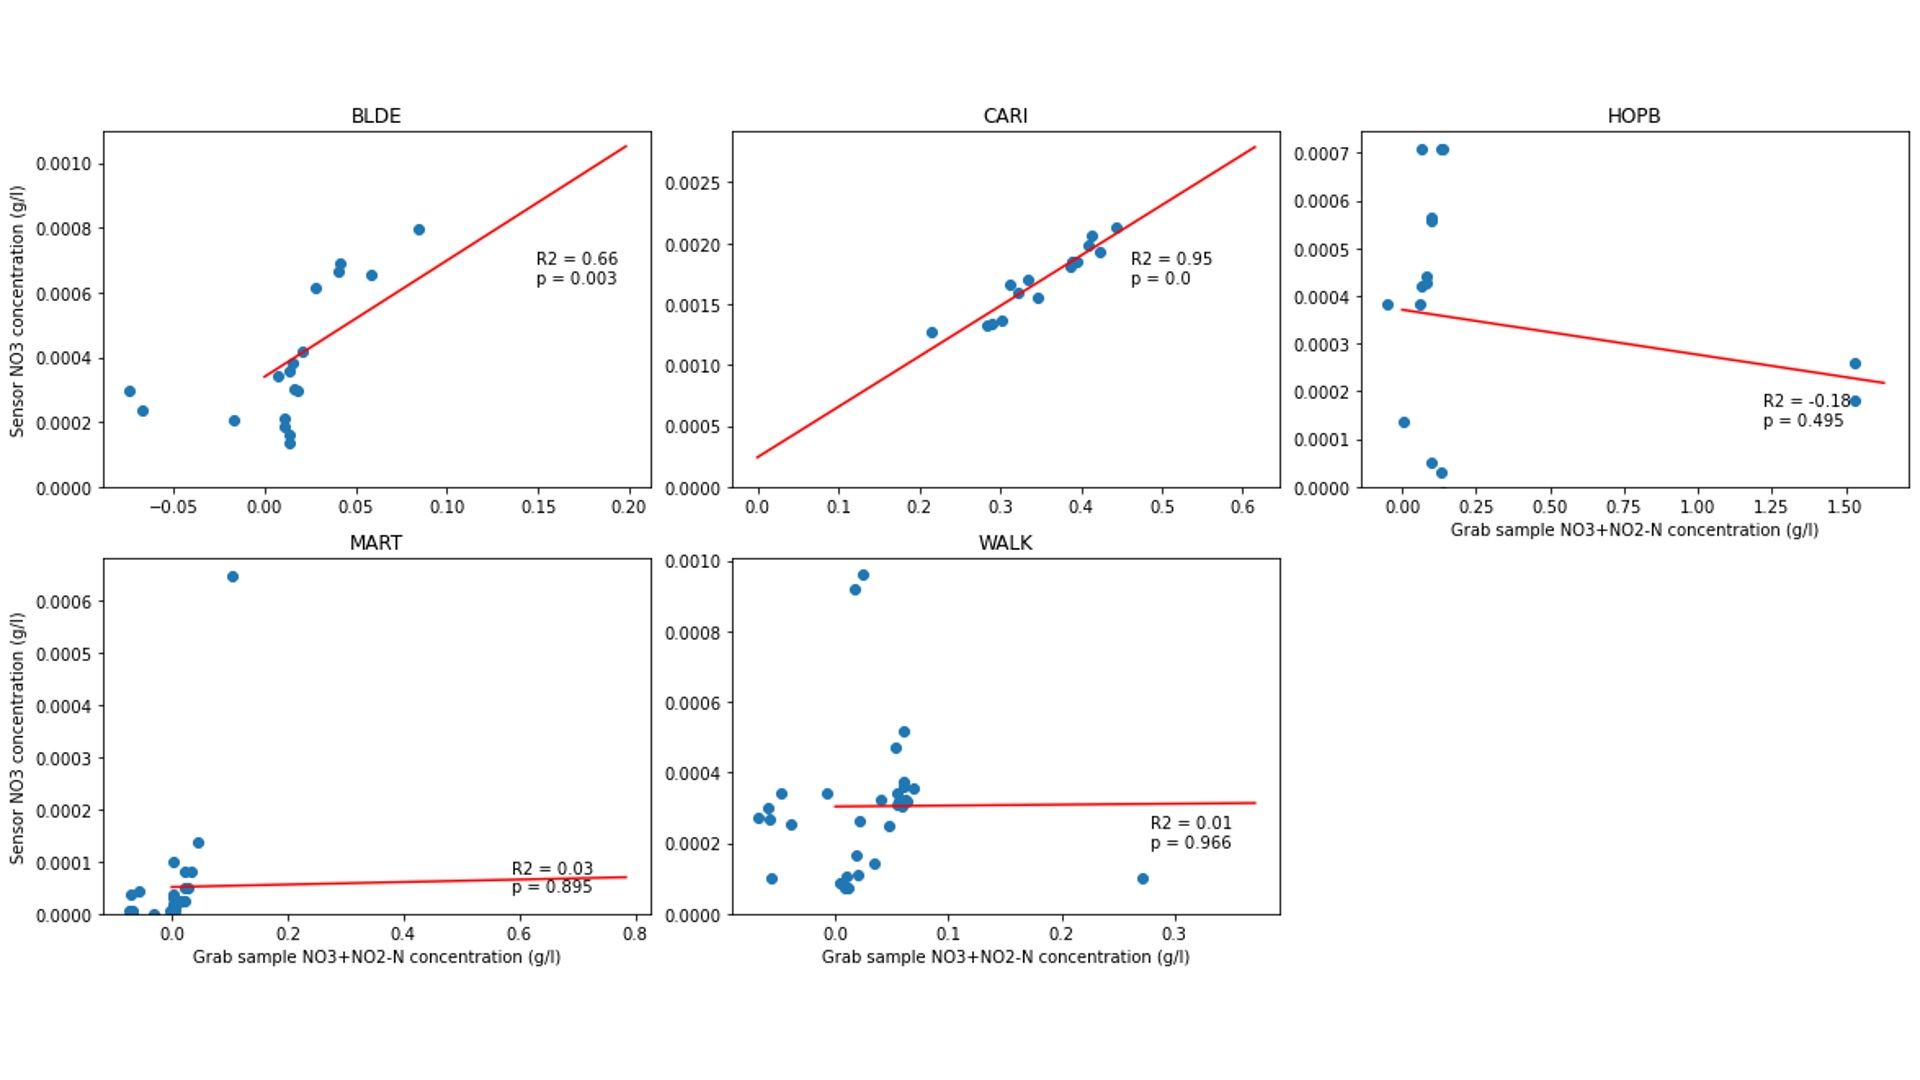

## 3.2 Discharge and nitrate

Continuous discharge measrements for 2019-2021 and NO3 concentrations are given in figure 4. Three storms were selected with the help of these figures to understand differences in hysteresis at each site. In an attempt to fill some of the data gaps made obvious in figure 4, a discharge-NO3 relationship was calculated for each site. However, stream NO3 concentrations are influenced by more variables than discharge, making such a relationship hard to estimate. Figure 5 illustrates discharge and NO3 concentration and the absent relationship between the two variables on an multi-year time scale. As such, individual storms were analyzed to better define this relationship for each site.  

Figure 4: Time series plots of discharge and nitreate concentration at all sites
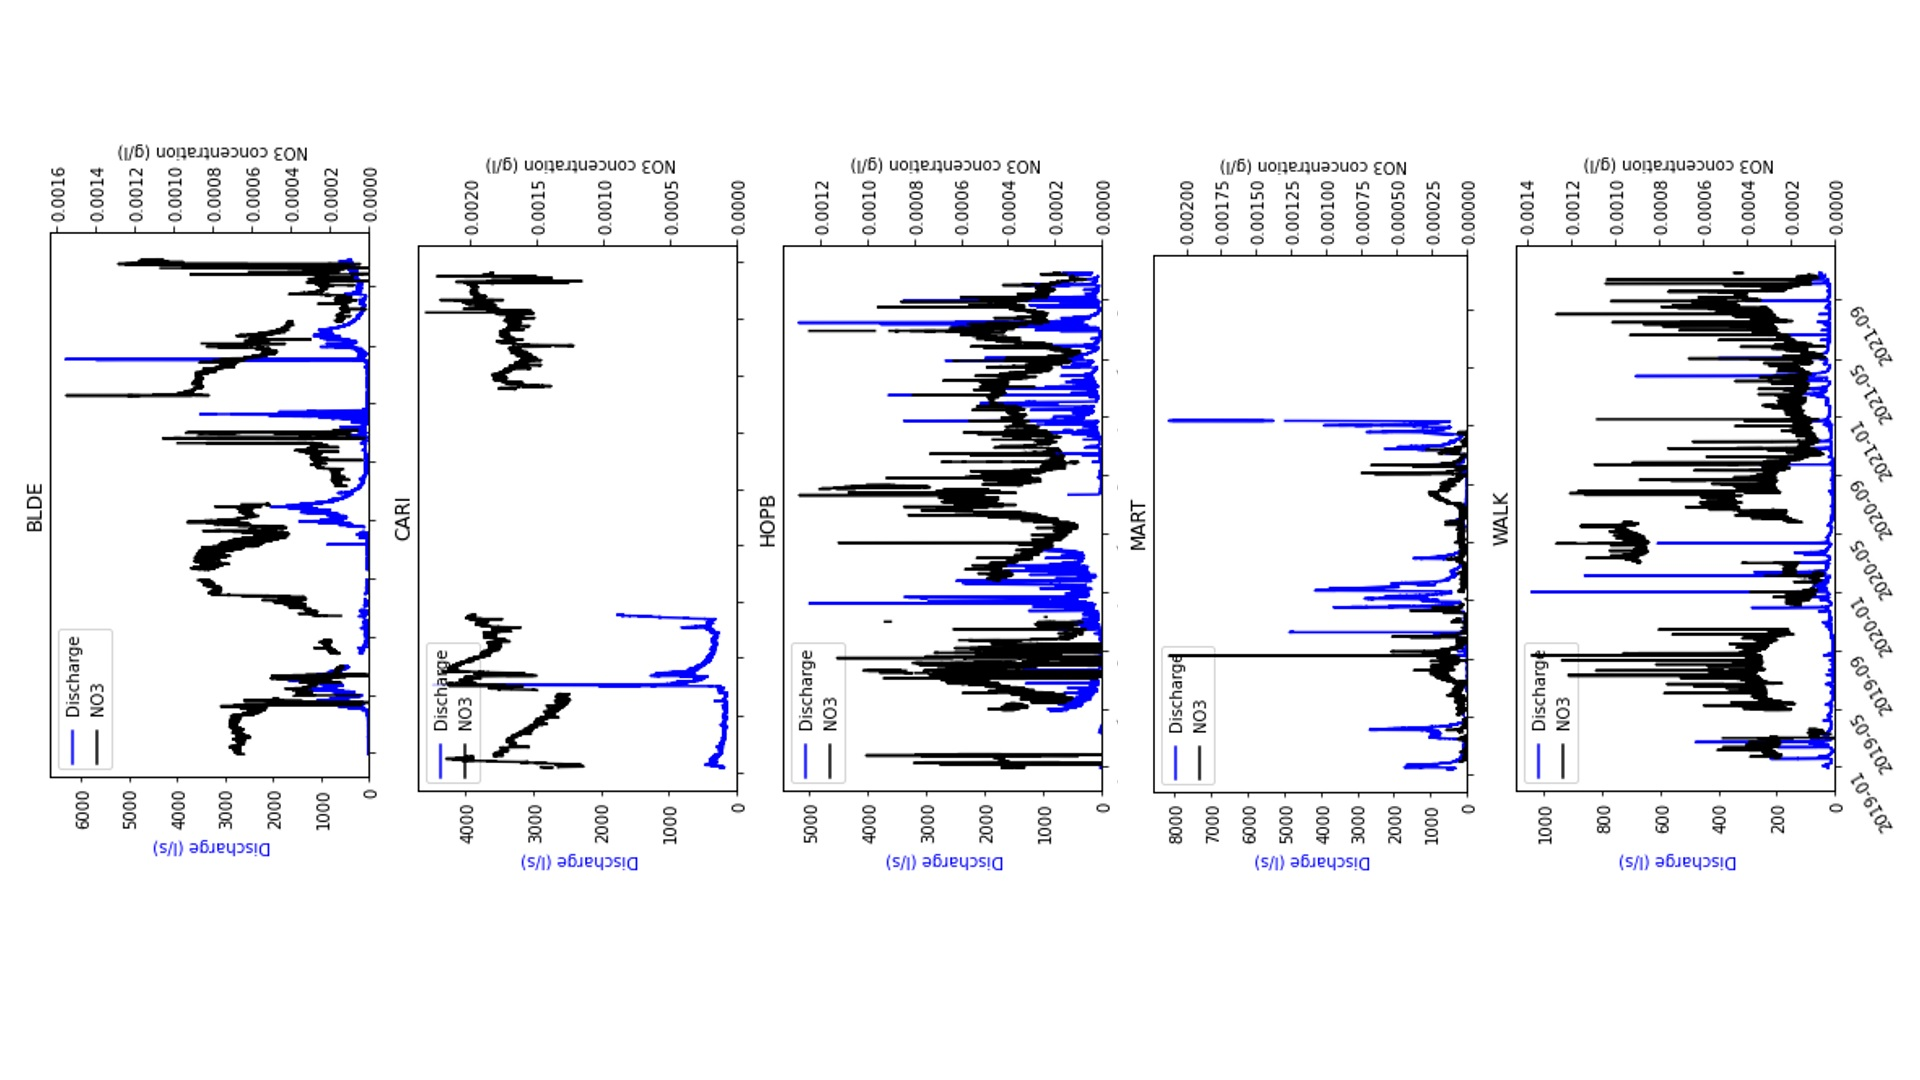


Figure 5: Discharge compared to sensor measured NO3 concentartions at all 5 sites.
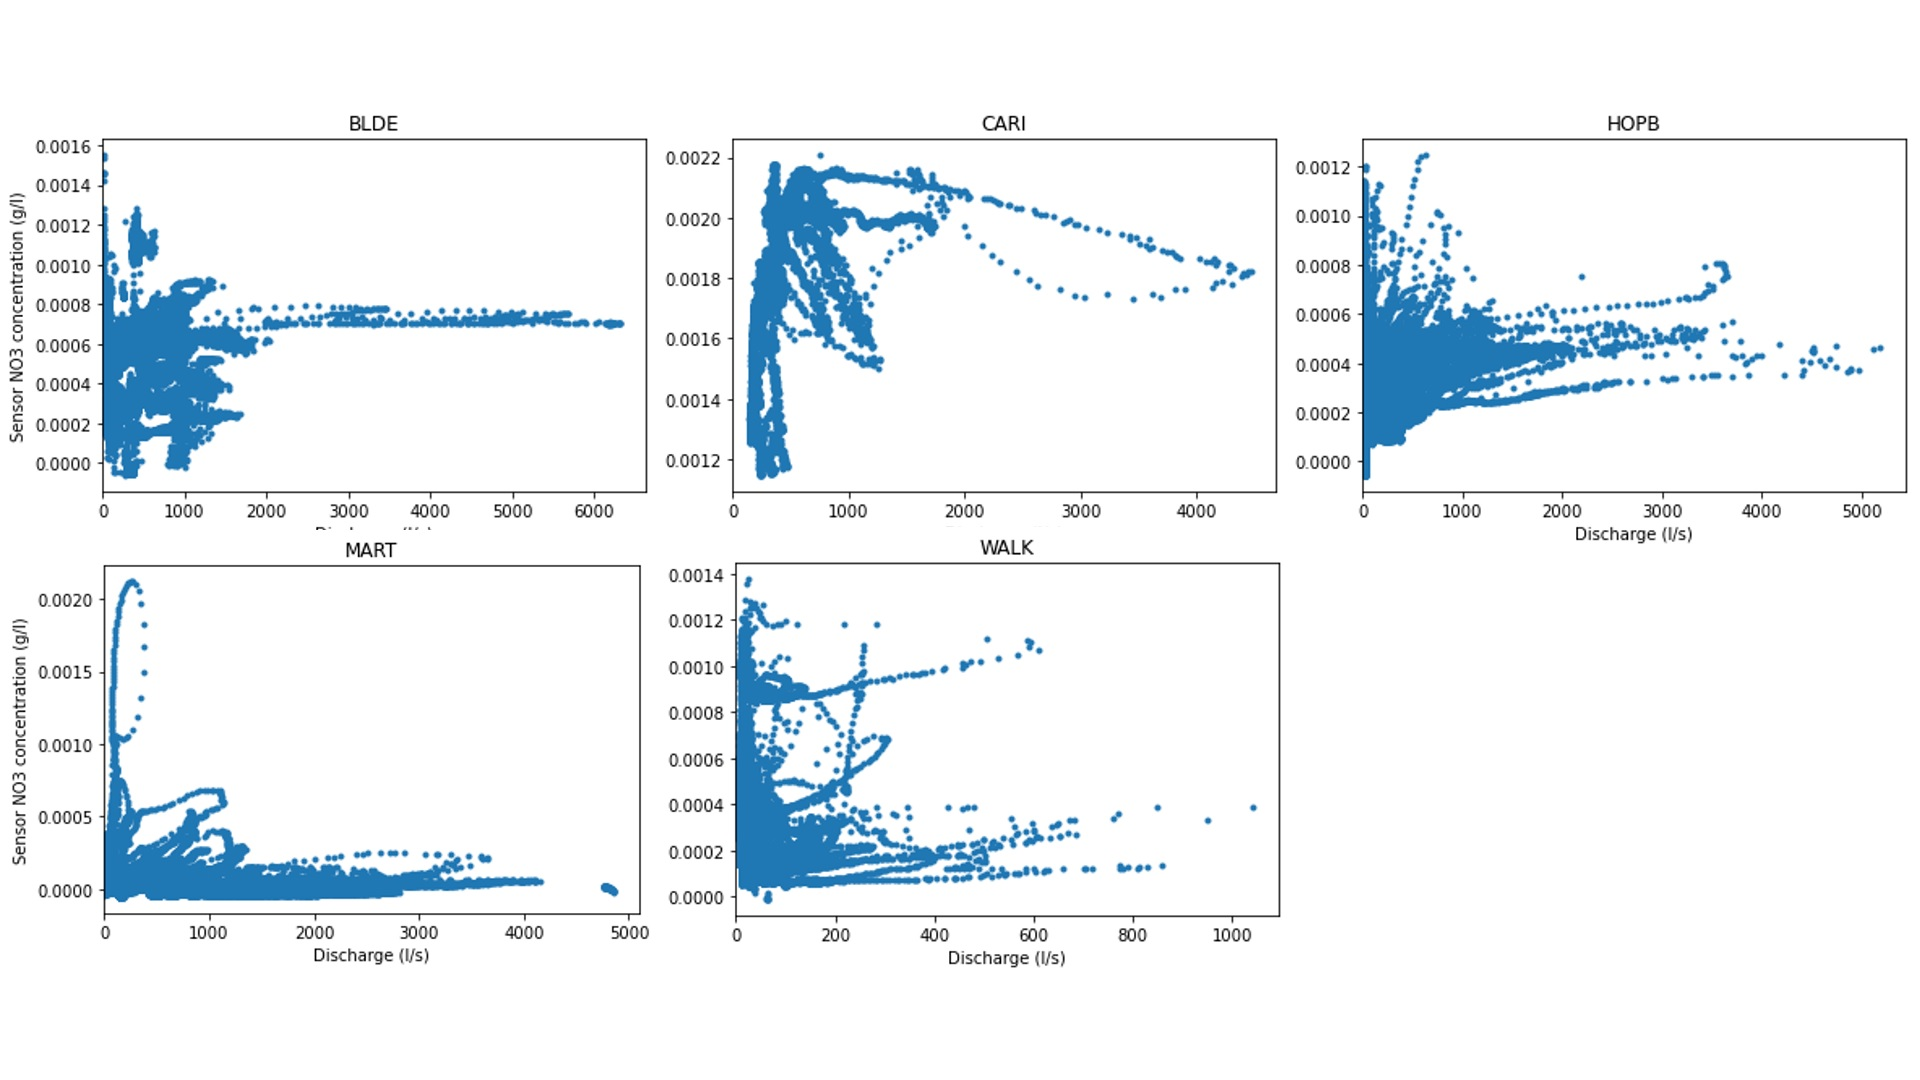

## 3.3 Discharge and nitrate hysteresis

Still a work in progress

# References
Donner, S. D., Kucharik, C. J., and Foley, J. A. (2004), Impact of changing land use practices on nitrate export by the Mississippi River, Global Biogeochem. Cycles, 18, GB1028, doi:10.1029/2003GB002093

Duncan, J. M., Welty, C., Kemper, J. T., Groffman, P. M., and Band, L. E. (2017), Dynamics of nitrate concentration-discharge patterns in an urban watershed, Water Resour. Res., 53, 7349– 7365, doi:10.1002/2017WR020500.

He, S., Lu, J. Contribution of baseflow nitrate export to non-point source pollution. Sci. China Earth Sci. 59, 1912–1929 (2016). https://doi.org/10.1007/s11430-016-5329-1

Jones, C. S., Schilling, K. E., Simpson, I. M., & Wolter, C. F. (2018). Iowa stream nitrate, discharge and precipitation: 30-year perspective. Environmental management, 62(4), 709-720.

Zhi, W., & Li, L. (2020). The shallow and deep hypothesis: subsurface vertical chemical contrasts shape nitrate export patterns from different land uses. Environmental Science & Technology, 54(19), 11915-11928. 

Zimmer, M. A., Pellerin, B., Burns, D., & Petrochenkov, G. (2019). Temporal variability in nitrate-discharge relationships in large rivers as revealed by high-frequency data. Water Resources Research, 55, 973– 989. https://doi.org/10.1029/2018WR023478 
